<font size="5">
  

# AirBnB pricing predication - Compairing Randon Forsts and XGBoost 
## COMP 4447 Data Scince Tools 1
Rodney Cordova

----



## Import the modules that

In [1]:
import pandas as pd 
import numpy as np 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

# Import the data

The dataset used in this analysis from the **[Inside Airbnb](http://insideairbnb.com/get-the-data.html)** site. Inside Airbnb aggregates data on listings and reviews from the AirBnB website. For this analysis we are using listings from Denver, Colorado.

In [2]:
url = 'http://data.insideairbnb.com/united-states/co/denver/2020-06-28/data/listings.csv.gz'
r = requests.get(url, allow_redirects=True)

open('listings.csv.gz', 'wb').write(r.content)

4872217

In [3]:
df = pd.read_csv('listings.csv.gz', compression='gzip')

In [4]:
df.head()

id                       listing_url       scrape_id last_scraped  \
0  177  https://www.airbnb.com/rooms/177  20200628212359   2020-06-29   
1  360  https://www.airbnb.com/rooms/360  20200628212359   2020-06-29   
2  364  https://www.airbnb.com/rooms/364  20200628212359   2020-06-29   
3  590  https://www.airbnb.com/rooms/590  20200628212359   2020-06-29   
4  592  https://www.airbnb.com/rooms/592  20200628212359   2020-06-29   

                                                name  \
0   Tiny Home in the Heart of the City- ECO FRIENDLY   
1  Sit in the Peaceful Garden of the Chickadee Co...   
2                Lodo / RiNo LOFT  via airport train   
3                  Comfortable  - and a great value!   
4                                            private   

                                             summary  \
0  160 sq ft + 80 sq ft loft for sleeping, Sleeps...   
1  Enjoy the famous Colorado weather and unplug i...   
2  Modern 1,000 square foot loft in the heart of ...   
3  Large guest room in my home, where I also live...   
4  This room is in the basement.  It does not hav...   

                                               space  \
0  Here's the fun details of this Tiny Home exper...   
1  Chickadee Cottage is the largest of our guest ...   
2  BRAND NEW FOR 2016 -  April 22, 2016 - the air...   
3  I have been enjoying welcoming many wonderful ...   
4  This is a basement room.  You can sometimes he...   

                                         description experiences_offered  \
0  160 sq ft + 80 sq ft loft for sleeping, Sleeps...                none   
1  Enjoy the famous Colorado weather and unplug i...                none   
2  Modern 1,000 square foot loft in the heart of ...                none   
3  Large guest room in my home, where I also live...                none   
4  This room is in the basement.  It does not hav...                none   

                               neighborhood_overview  ... instant_bookable  \
0  Quiet neighborhood next to park, creeks and bi...  ...                f   
1  The cottage is located in the center of Lower ...  ...                f   
2  Ten brewpubs within walking distance, two grea...  ...                f   
3  I love the diversity of my neighborhood and it...  ...                f   
4                                                NaN  ...                f   

  is_business_travel_ready          cancellation_policy  \
0                        f  strict_14_with_grace_period   
1                        f  strict_14_with_grace_period   
2                        f  strict_14_with_grace_period   
3                        f                     flexible   
4                        f                     flexible   

  require_guest_profile_picture require_guest_phone_verification  \
0                             f                                f   
1                             t                                t   
2                             f                                f   
3                             f                                f   
4                             f                                f   

   calculated_host_listings_count  \
0                               3   
1                               2   
2                               1   
3                               2   
4                               2   

   calculated_host_listings_count_entire_homes  \
0                                            3   
1                                            2   
2                                            1   
3                                            0   
4                                            0   

  calculated_host_listings_count_private_rooms  \
0                                            0   
1                                            0   
2                                            0   
3                                            2   
4                                            2   

   calculated_host_listings_count_share

In [5]:
df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
name                                             object
                                                 ...   
calculated_host_listings_count                    int64
calculated_host_listings_count_entire_homes       int64
calculated_host_listings_count_private_rooms      int64
calculated_host_listings_count_shared_rooms       int64
reviews_per_month                               float64
Length: 106, dtype: object

## 1. Data Cleaning 

In [6]:
#columns
for i in df.columns:
    print(i)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

### Feature Reduction

In [7]:
#remove urls 
df.drop(columns = ['listing_url','thumbnail_url','medium_url','picture_url',
                  'xl_picture_url','host_url','host_thumbnail_url','host_picture_url'], inplace = True)

In [8]:
#remove text features
df.drop(columns = ['name','summary','space','description','neighborhood_overview',
                  'notes','transit','access','interaction','house_rules','host_about',
                  'host_verifications','amenities','jurisdiction_names','host_name','host_location','calendar_updated'
                  ,'license'], inplace = True)

In [9]:
#duplicate features.
# street = City, state, country - street removed
# mart_location = City, state - market_location removed
# country_code = country - country_code removed 
# host_listings_count = host_total_listings_count - host_listings_count removed
# market = Denver

df.drop(columns = ['street','smart_location','country_code','host_listings_count','market'],inplace = True)

In [10]:
#remove signle unique Value
df['state'] = df['state'].str.lower()
for i in df.columns:
    if df[i].nunique() == 1 or df[i].nunique() == 0:
        print(i + " : " + str(df[i].nunique()) + " : Unique Value =" +str(df[i].unique()))

scrape_id : 1 : Unique Value =[20200628212359]
experiences_offered : 1 : Unique Value =['none']
neighbourhood_group_cleansed : 0 : Unique Value =[nan]
state : 1 : Unique Value =['co']
country : 1 : Unique Value =['United States']
has_availability : 1 : Unique Value =['t']
is_business_travel_ready : 1 : Unique Value =['f']


In [11]:
df.drop(columns = ['scrape_id','experiences_offered','has_availability',
                   'is_business_travel_ready','neighbourhood_group_cleansed','country','state'],inplace = True)

In [12]:
#removed noncleased
df.drop(columns =['neighbourhood'],inplace = True)

### Feature Engineering 

In [13]:
#convert host_response_rate and host_acceptance_rate to floats 
df['host_response_rate'] = df['host_response_rate'].str.replace('%', '').astype('float').div(100)
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype('float').div(100)

In [14]:
#convert dollar columns to floats
dollar = ['price','weekly_price','monthly_price','security_deposit','cleaning_fee','extra_people']
for col in dollar:
    df[col] = df[col].str.replace('$', '').str.replace(',', '').astype('float')

In [15]:
#covert date to year and get the the differince in new column:
df['host_since'] = df['host_since'].astype('str')
df['host_since'] = pd.to_datetime(df['host_since'])
df['last_scraped'] = df['last_scraped'].astype('str')
df['last_scraped'] = pd.to_datetime(df['last_scraped'])

df['host_for_years'] = (((df['last_scraped'] - df['host_since'])/ np.timedelta64(1, 'D')))/365

In [16]:
#convert first_reveiw and last reveiw in years. 
df['first_review'] = df['first_review'].astype('str')
df['first_review'] = ((df['last_scraped'] - pd.to_datetime(df['first_review'])) / np.timedelta64(1, 'D'))/365
df['last_review'] = df['last_review'].astype('str')
df['last_review'] = ((df['last_scraped'] - pd.to_datetime(df['last_review'])) / np.timedelta64(1, 'D'))/365

In [18]:
#remove co from zip
df.zipcode = df.zipcode.str.strip('co ')

In [19]:
for i in df.columns:
    print(i + " : " + str(df[i].dtypes))

id : int64
last_scraped : datetime64[ns]
host_id : int64
host_since : datetime64[ns]
host_response_time : object
host_response_rate : float64
host_acceptance_rate : float64
host_is_superhost : object
host_neighbourhood : object
host_total_listings_count : int64
host_has_profile_pic : object
host_identity_verified : object
neighbourhood_cleansed : object
city : object
zipcode : object
latitude : float64
longitude : float64
is_location_exact : object
property_type : object
room_type : object
accommodates : int64
bathrooms : float64
bedrooms : float64
beds : float64
bed_type : object
square_feet : float64
price : float64
weekly_price : float64
monthly_price : float64
security_deposit : float64
cleaning_fee : float64
guests_included : int64
extra_people : float64
minimum_nights : int64
maximum_nights : int64
minimum_minimum_nights : int64
maximum_minimum_nights : int64
minimum_maximum_nights : int64
maximum_maximum_nights : int64
minimum_nights_avg_ntm : float64
maximum_nights_avg_ntm : fl

In [20]:
#remove scrape and date features
df.drop(columns = ['id','last_scraped','calendar_last_scraped','host_since'], inplace = True)

In [21]:
#change all catigoricals to lower for use in one hot encomding later
lower_cat = ['host_response_time','host_is_superhost','host_neighbourhood','host_has_profile_pic',
            'host_identity_verified','neighbourhood_cleansed','city','zipcode','property_type','room_type',
            'bed_type','requires_license','instant_bookable','cancellation_policy','require_guest_profile_picture',
            'require_guest_phone_verification']

for i in lower_cat:
    df[i] = df[i].str.lower()


### Missing Values

In [22]:
#missing 
df.isnull().sum().sum()

22371

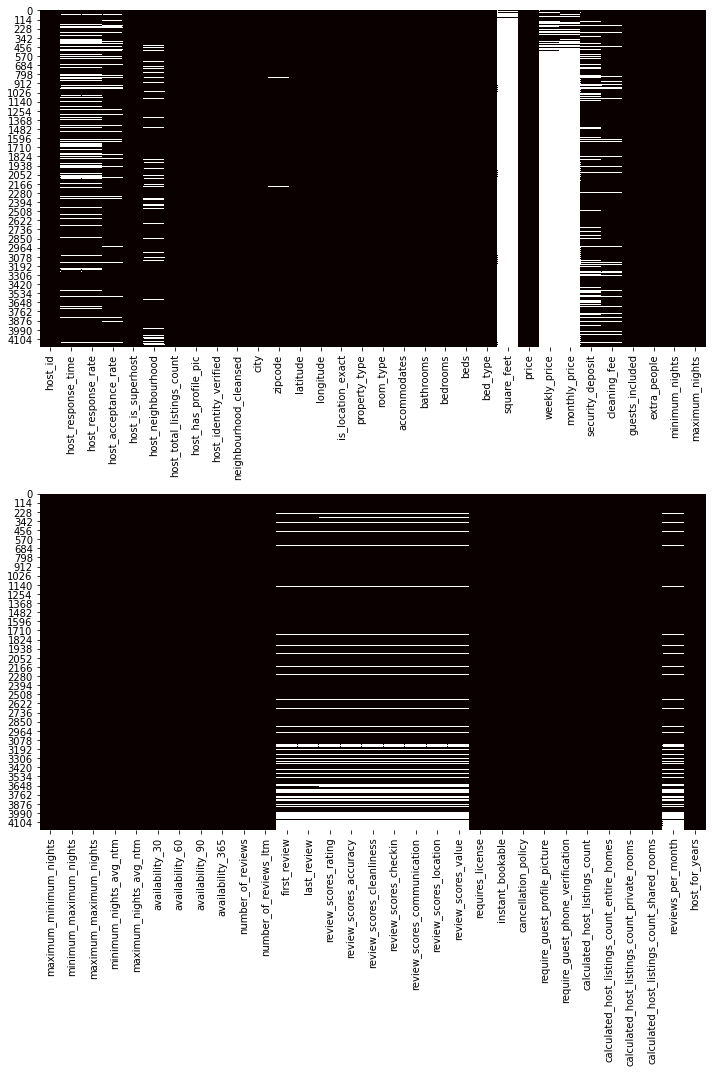

In [23]:
%matplotlib inline 
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
fig, axes = plt.subplots(2, 1, figsize = (10,15))
sns.heatmap(df.iloc[:, 0:32].isnull(), cbar=False, cmap='hot',ax = axes[0])
sns.heatmap(df.iloc[:, 33:].isnull(), cbar=False, cmap='hot',ax = axes[1])
plt.tight_layout()
plt.show()

In [24]:
for i in df.columns:
    missing_rate = df[i].isnull().sum() / df[i].shape[0]
    if missing_rate >0.5:
        print(i + " - " + str(missing_rate))

square_feet - 0.9959523809523809
weekly_price - 0.9319047619047619
monthly_price - 0.9414285714285714


In [25]:
df.drop(columns = ['square_feet','weekly_price','monthly_price'],inplace = True)

In [26]:
#splitting df based on method
df_forest = df
df_boost = df 

In [27]:
# for forest impute missing data. For float / int column impute = mean. For catigorical column impute = mode   
for i in df_forest.columns:
    if df_forest[i].dtype == float or df_forest[i].dtype == int:
        df_forest[i].fillna(df_forest[i].mean(),inplace = True)
    else:
        df_forest[i].fillna(df_forest[i].mode(), inplace = True)
 

df_forest['host_response_time'].fillna('within an hour', inplace = True)
df_forest['host_neighbourhood'].fillna('five points', inplace = True)
df_forest['host_response_time'].fillna('within an hour', inplace = True)
df_forest['zipcode'].fillna('80211', inplace = True)

df_forest.isnull().sum().sum()

0

In [28]:
#for xgboost repalce missing values with 0
df_boost.fillna(0,inplace = True)
df_boost.isnull().sum().sum()

0

## 2. Data visualization

In [29]:
for i in df_forest.columns:
    if df_forest[i].dtype == float or df_forest[i].dtype == int:
        print(i)

host_id
host_response_rate
host_acceptance_rate
host_total_listings_count
latitude
longitude
accommodates
bathrooms
bedrooms
beds
price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_nights_avg_ntm
maximum_nights_avg_ntm
availability_30
availability_60
availability_90
availability_365
number_of_reviews
number_of_reviews_ltm
first_review
last_review
review_scores_rating
review_scores_accuracy
review_scores_cleanliness
review_scores_checkin
review_scores_communication
review_scores_location
review_scores_value
calculated_host_listings_count
calculated_host_listings_count_entire_homes
calculated_host_listings_count_private_rooms
calculated_host_listings_count_shared_rooms
reviews_per_month
host_for_years


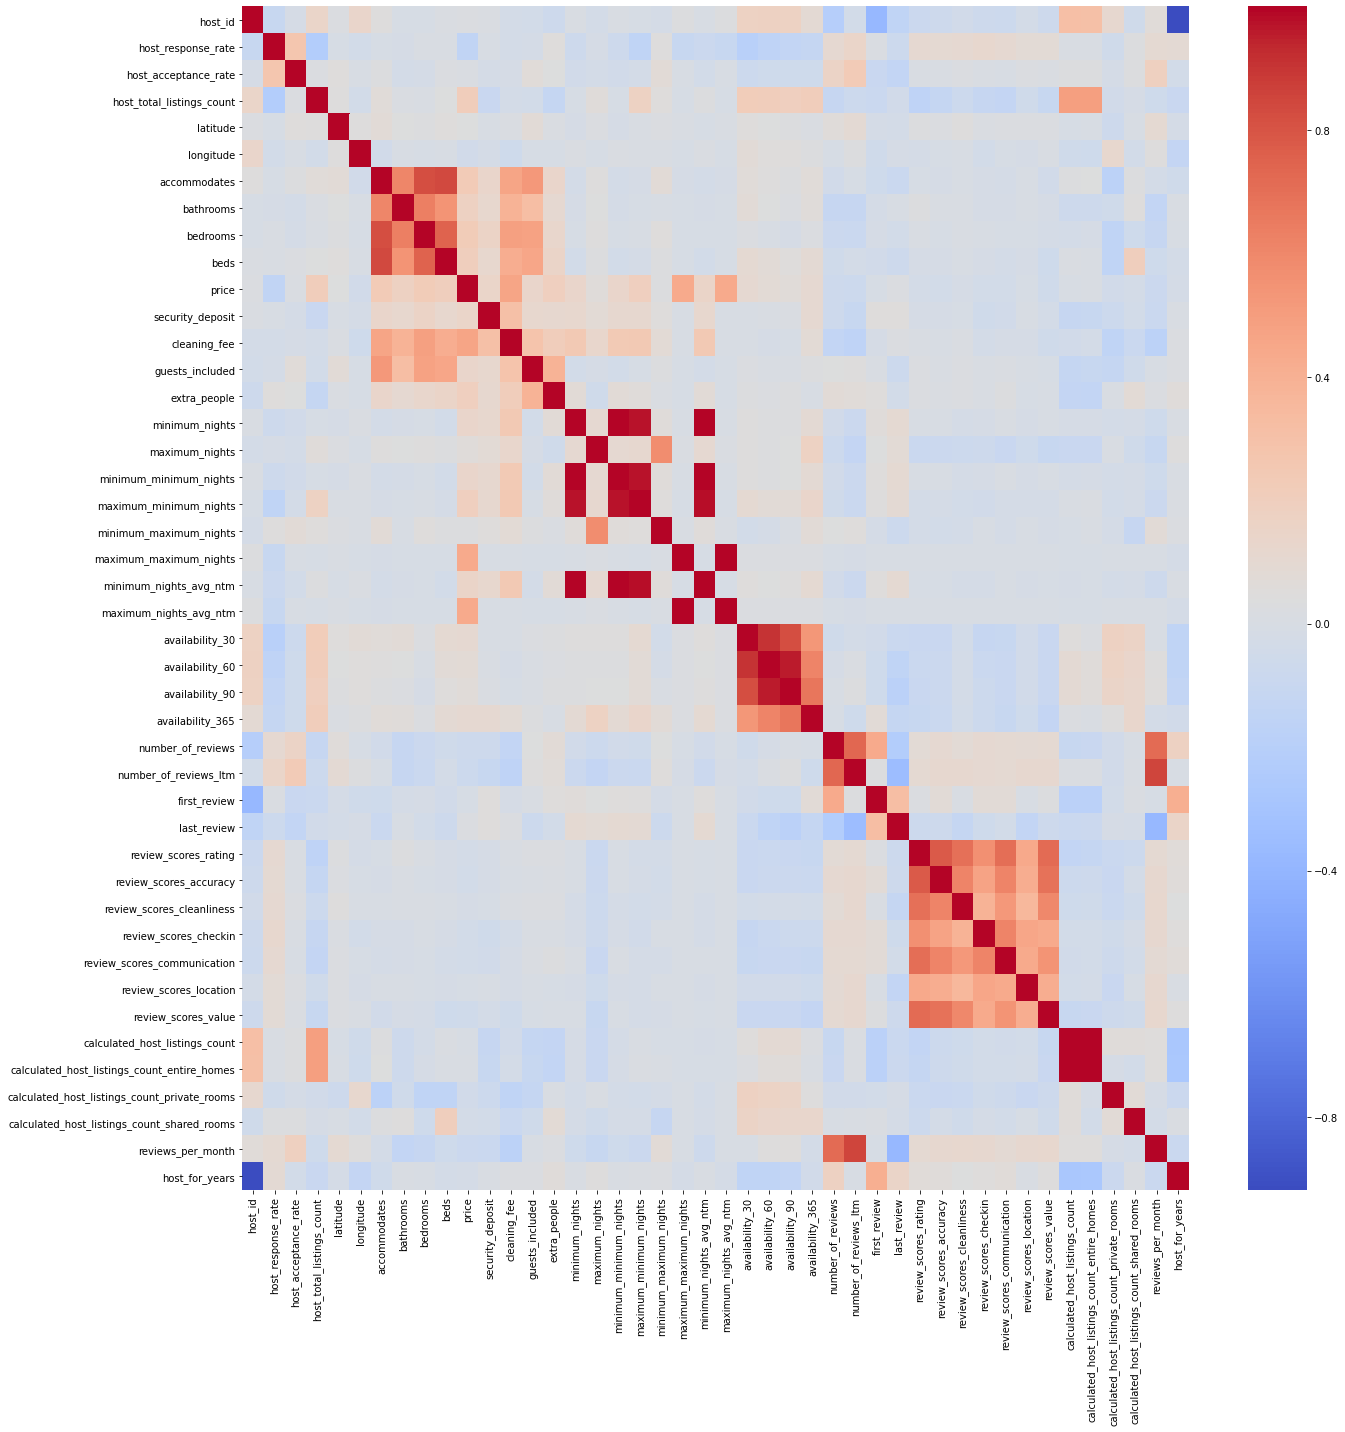

In [30]:
# num = [x for x in df.columns if df[x].dtype == float or df[x].dtype == int]
# df_num = df[num]
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(df.corr(), cmap = 'coolwarm')
plt.tight_layout()
plt.show()
